In [1]:
from bs4 import BeautifulSoup
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [2]:
#Exception

class InputError(Exception) :
    def __init__(self, msg) :
        self._message = msg

In [3]:
#decorator

def checkTime(func) :
    import time
    
    def newFunc(*args, **kwargs) :
        start = time.time()
        func(*args, **kwargs)
        end = time.time()
        exetime = end-start
        print("It took %.1f seconds to get the data from the web\n" %exetime)
    return newFunc

In [4]:
class loading() :
    @checkTime
    def __init__(self) :
        url = "http://insideairbnb.com/get-the-data.html"
        response = requests.get(url)
        html = response.text
        self.city = None
        self.whole_text = BeautifulSoup(html, 'lxml')
        self.city_list = [str(i) for i in self.whole_text.select('h2')]
    
    def find_city(self, cityname) :
        self.city = cityname.lower()
        city_pat1 = re.compile(r'(?<=<h2>)(?P<city>.*),\s(.*?),\s(.*,)\s(?P<country>\b.*)(?=</h2>)')
        city_pat2 = re.compile(r'(?<=<h2>)(?P<city>.*),\s(.*?),\s(?P<country>\b.*)(?=</h2>)')
        
        airbnb = list()

        for i in self.city_list :
            a = city_pat1.search(i)
            if a :
                airbnb.append(a.group('city').lower())
            elif city_pat2.search(i) :
                b = city_pat2.search(i)
                airbnb.append(b.group('city').lower())
                
        if self.city in airbnb :
            print("You can see the listings of airbnb in %s." %self.city)
        else :
            raise InputError("Invalid input.")
    
    def crawl_csv(self) :
        a = self.whole_text.select('td')
        for i in range(len(a)) :
            if(self.city in a[i-1].text.lower()) & (a[i].text=="listings.csv") :
                csvfile = a[i]
                break;
        
        csv_pat = re.compile(r'<a href="(.*)\b"')
        csv = csv_pat.search(str(csvfile)).group(1)
        file = pd.read_csv(csv, encoding="UTF-8")
        return file

In [5]:
class airbnb_info() :
    def __init__(self, file) :
        self.file = file
    
    def basic_info(self) :
        fig, ax = plt.subplots(figsize=(25, 15))
        sns.countplot(y="neighbourhood", data=self.file)
        plt.title('The distribution of Airbnb', fontsize=40, pad=40)
        plt.rcParams["ytick.labelsize"] = 20
        plt.tight_layout()
        
    def room_type_info(self) :
        typ = list(self.file['room_type'].value_counts().index)
        num = list(self.file['room_type'].value_counts())
        plt.figure(figsize=(9, 8))
        plt.pie(num, colors=['pink', 'skyblue', 'lemonchiffon', 'olivedrab'])
        plt.legend(typ, loc='upper right')
        plt.title("The percentage of Room types")
        plt.show()
        
    def price_info(self) :
        print("The mean of the airbnb is %.2f" %float(self.file['price'].mean()))
        
        mini = input("\nMinimum price : ")
        maxi = input("\nMaximum price : ")

        target_df = self.file[(self.file['price']>=int(mini))&(self.file['price']<=int(maxi))]
        neighlist = list(self.file['neighbourhood'].value_counts().index)
        neigh_dist = list(target_df['neighbourhood'].value_counts())

        newdf = pd.DataFrame(neigh_dist, index=neighlist, columns=['number of airbnb'])
        newdf['key'] = range(len(newdf))
        print(newdf)

        region_k = int(input("\nInput the key value you want to see the recommended airbnb list : "))
        print("\n")
        key = list(newdf[newdf['key']==region_k].index)[0]
        print(key)

        a = target_df[target_df['neighbourhood']==key]
        a = a.sort_values(by=['reviews_per_month'], ascending=False)
        print(a[['name', 'price', 'room_type', 'number_of_reviews']][:10])

In [10]:
#main

trip = loading()

which_city = input("Where do you wanna go? Enter the name of the city : ")

trip.find_city(which_city)

csv = trip.crawl_csv()

It took 28.6 seconds to get the data from the web

Where do you wanna go? Enter the name of the city : munich
You can see the listings of airbnb in munich.


In [11]:
#main 2

data = airbnb_info(csv)

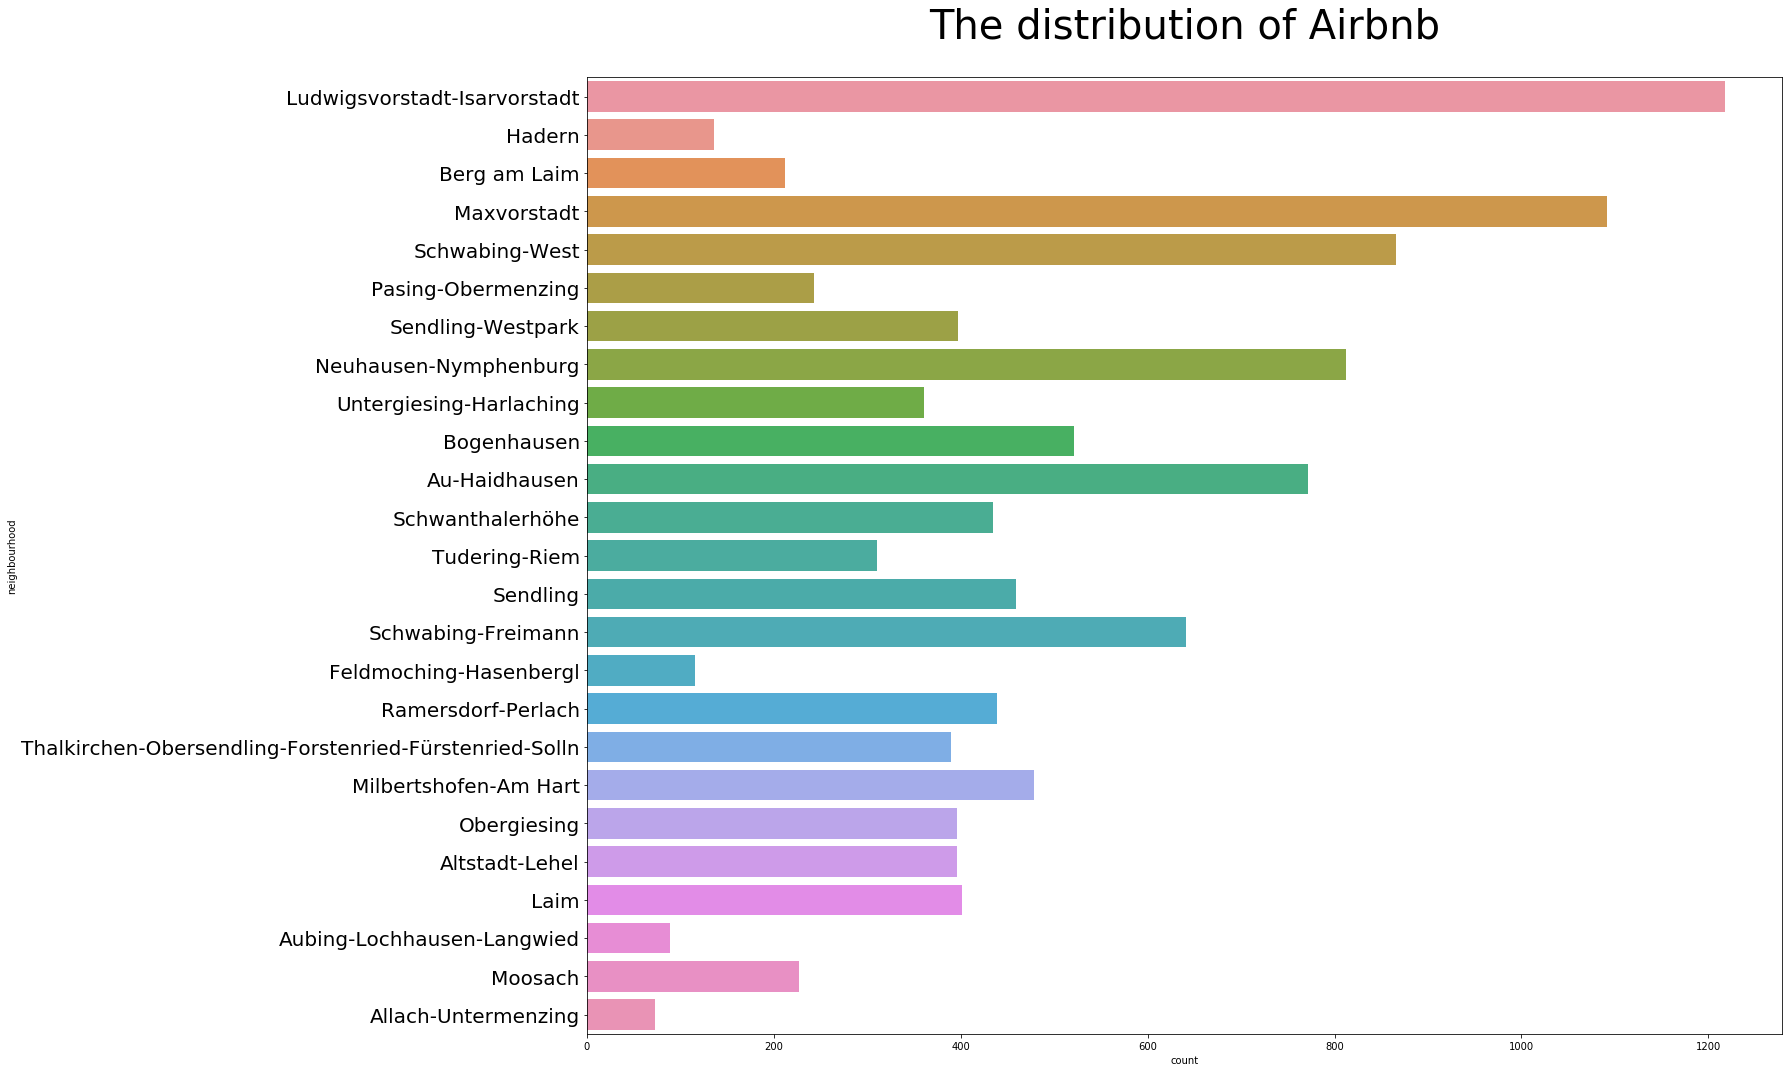

In [12]:
data.basic_info()

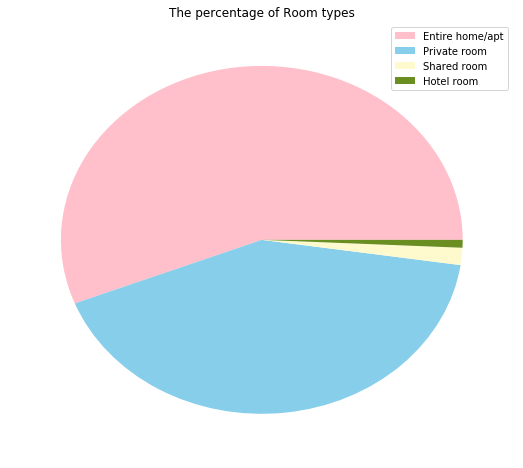

In [13]:
data.room_type_info()

In [14]:
data.price_info()

The mean of the airbnb is 116.34

Minimum price : 90

Maximum price : 150
                                                    number of airbnb  key
Ludwigsvorstadt-Isarvorstadt                                     401    0
Maxvorstadt                                                      340    1
Schwabing-West                                                   237    2
Neuhausen-Nymphenburg                                            235    3
Au-Haidhausen                                                    211    4
Schwabing-Freimann                                               171    5
Bogenhausen                                                      163    6
Milbertshofen-Am Hart                                            154    7
Sendling                                                         143    8
Ramersdorf-Perlach                                               140    9
Schwanthalerhöhe                                                 115   10
Laim                                  